#### In this notebook we’ll get the BBC text archive. Our job is to tokenize the dataset, removing common stopwords. A great source of these stop words can be found [here](https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js).
####  This BBC news reports dataset contains articles that are classified into a number of different categories.
####  Design a neural network that can be trained on this dataset to accurately determine what words determine what category. 
####  Create the vecs.tsv and meta.tsv files and load them into the embedding projector.

In [19]:
# Import libraries
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import io

Import Dataset

In [ ]:
# Download the .csv file from bbc news report
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
#     -O D:/Tanuj/Projects/Deep_Learning_TensorFlow/Natural-Language-Processing-in-TensorFlow/bbc-text.csv

In [6]:
vocab_size = 1000          # Define the vocabulary size to be used by the tokenizer.
embedding_dim = 16         # Dimension of the dense embedding. Each word will be represented as a 16-dimensional vector.
max_length = 120           # Maximum length of all sequences. Sequences longer than this will be truncated, and shorter ones will be padded.
trunc_type = 'post'        # Truncate sequences from the end (post) if they exceed the maximum length.
padding_type = 'post'      # Pad sequences at the end (post) to ensure all sequences are of the same length.
oov_tok = "<OOV>"          # Token used to represent words that are out-of-vocabulary (i.e., not present in the training set).
training_portion = .8      # (80:20) (train:val) dataset split

In [7]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


Now, we will read bbc file using a csv reader and after removing all stopwords from each sentance, create a list of lables and sentances

In [8]:
with open("bbc_dataset/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

Define Train-Validation Split

In [9]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)  # Initialize the tokenizer with a vocabulary size limit and an OOV token.
tokenizer.fit_on_texts(train_sentences)  # Fit the tokenizer on the training sentences to create the word index.

word_index = tokenizer.word_index  # Get the word index dictionary that maps words to their index.

# Convert the training sentences to sequences of integers.
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the training sequences to ensure they all have the same length.
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# Print the length of the first training sequence before and after padding.
print(len(train_sequences[0]))  
print(len(train_padded[0]))     

# Print the length of the second training sequence before and after padding.
print(len(train_sequences[1]))  
print(len(train_padded[1]))     

# Print the length of the eleventh training sequence before and after padding.
print(len(train_sequences[10])) 
print(len(train_padded[10]))     

449
120
200
120
192
120


In [11]:
# Convert the validation sentences to sequences of integers.
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
# Pad the validation sequences to ensure they all have the same length.
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [12]:
label_tokenizer = Tokenizer()  # Initialize a tokenizer for the labels.
label_tokenizer.fit_on_texts(labels)  # Fit the tokenizer on the labels to create the label index.

# Convert the training labels to sequences of integers.
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
# Convert the validation labels to sequences of integers.
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# Print the first three training label sequences and their shape.
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
# Print the first three validation label sequences and their shape.
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [13]:
# Initialize a Sequential model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
# Compile the model with sparse categorical crossentropy loss, the Adam optimizer, and accuracy as a metric.
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


train the model

In [14]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 2s - loss: 1.7684 - accuracy: 0.2646 - val_loss: 1.7359 - val_accuracy: 0.3461 - 2s/epoch - 29ms/step
Epoch 2/30
56/56 - 0s - loss: 1.6956 - accuracy: 0.3157 - val_loss: 1.6437 - val_accuracy: 0.2607 - 322ms/epoch - 6ms/step
Epoch 3/30
56/56 - 0s - loss: 1.5852 - accuracy: 0.2826 - val_loss: 1.5239 - val_accuracy: 0.3933 - 319ms/epoch - 6ms/step
Epoch 4/30
56/56 - 0s - loss: 1.4398 - accuracy: 0.4427 - val_loss: 1.3742 - val_accuracy: 0.4697 - 314ms/epoch - 6ms/step
Epoch 5/30
56/56 - 0s - loss: 1.2642 - accuracy: 0.5736 - val_loss: 1.2023 - val_accuracy: 0.6292 - 311ms/epoch - 6ms/step
Epoch 6/30
56/56 - 0s - loss: 1.0818 - accuracy: 0.7213 - val_loss: 1.0354 - val_accuracy: 0.7640 - 320ms/epoch - 6ms/step
Epoch 7/30
56/56 - 0s - loss: 0.9049 - accuracy: 0.8191 - val_loss: 0.8765 - val_accuracy: 0.8382 - 327ms/epoch - 6ms/step
Epoch 8/30
56/56 - 0s - loss: 0.7457 - accuracy: 0.8837 - val_loss: 0.7422 - val_accuracy: 0.8652 - 319ms/epoch - 6ms/step
Epoch 9/30
56/56 -

plot accuracy and loss curve

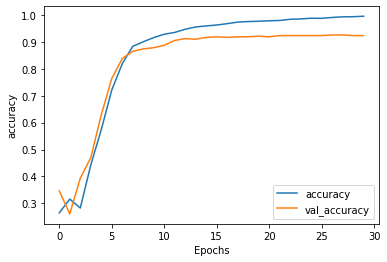

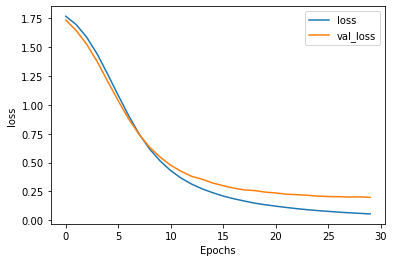

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
# Create a dictionary that maps integer indices back to words.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Define a function to decode a sequence of integers back into a sentence.
def decode_sentence(text):
    # Join the words corresponding to the integer indices into a single string.
    # If an index is not found in the reverse_word_index, replace it with '?'.
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [18]:
# Get the first layer of the model, which is the Embedding layer.
e = model.layers[0]
# Extract the weights (embedding matrix) from the Embedding layer.
weights = e.get_weights()[0]
# Print the shape of the embedding matrix.
print(weights.shape)  # (vocab_size, embedding_dim)

(1000, 16)


In [20]:
# Open 'vecs.tsv' file for writing the word vectors, with UTF-8 encoding.
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# Open 'meta.tsv' file for writing the metadata (words), with UTF-8 encoding.
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Iterate over the range from 1 to vocab_size (excluding 0 as it is typically reserved for padding).
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]  # Get the word corresponding to the current index.
    embeddings = weights[word_num]       # Get the embedding vector for the current word.
    
    out_m.write(word + "\n")  # Write the word to the metadata file followed by a newline.
    
    # Write the embedding vector to the vectors file, with values separated by tabs.
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close() 